# 0. Import packages

In [1]:
!pip install tslearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.2/358.2 kB 25.8 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import requests
from tqdm import tqdm
import pickle

import tslearn
from tslearn.clustering import TimeSeriesKMeans, KShape, KernelKMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import linear_model

# 1. Clustering

## (reference) Get and filter S&P500 data

In [3]:
"""
Get S&P500 tickers
"""

# Read and print the stock tickers that make up S&P500
tickers = pd.read_html(
    'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
tickers.head()

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [4]:
tickers_list = tickers.Symbol.to_list()
company_name = tickers.Security.to_list()
company = dict(zip(tickers_list, company_name))
print(company)

{'MMM': '3M', 'AOS': 'A. O. Smith', 'ABT': 'Abbott', 'ABBV': 'AbbVie', 'ACN': 'Accenture', 'ATVI': 'Activision Blizzard', 'ADM': 'ADM', 'ADBE': 'Adobe Inc.', 'ADP': 'ADP', 'AAP': 'Advance Auto Parts', 'AES': 'AES Corporation', 'AFL': 'Aflac', 'A': 'Agilent Technologies', 'APD': 'Air Products and Chemicals', 'AKAM': 'Akamai', 'ALK': 'Alaska Air Group', 'ALB': 'Albemarle Corporation', 'ARE': 'Alexandria Real Estate Equities', 'ALGN': 'Align Technology', 'ALLE': 'Allegion', 'LNT': 'Alliant Energy', 'ALL': 'Allstate', 'GOOGL': 'Alphabet Inc. (Class A)', 'GOOG': 'Alphabet Inc. (Class C)', 'MO': 'Altria', 'AMZN': 'Amazon', 'AMCR': 'Amcor', 'AMD': 'AMD', 'AEE': 'Ameren', 'AAL': 'American Airlines Group', 'AEP': 'American Electric Power', 'AXP': 'American Express', 'AIG': 'American International Group', 'AMT': 'American Tower', 'AWK': 'American Water Works', 'AMP': 'Ameriprise Financial', 'ABC': 'AmerisourceBergen', 'AME': 'Ametek', 'AMGN': 'Amgen', 'APH': 'Amphenol', 'ADI': 'Analog Devices', 

In [5]:
"""
Get market cap of each ticker
"""


# get market cap of each ticker, in a dictionary
market_cap = {}
for ticker in tqdm(tickers_list):
    try:
        market_cap[ticker] = yf.Ticker(ticker).info['marketCap']
    except:
        print(ticker) # BRK.B, BF.B



 13%|█▎        | 67/503 [00:07<00:49,  8.75it/s]

BRK.B


 17%|█▋        | 83/503 [00:10<00:54,  7.70it/s]

BF.B


100%|██████████| 503/503 [00:51<00:00,  9.86it/s]


In [6]:
# save market cap as a pickle
with open('market_cap.pickle', 'wb') as handle:
    pickle.dump(market_cap, handle, protocol=pickle.HIGHEST_PROTOCOL)

# read market cap from pickle
with open('market_cap.pickle', 'rb') as handle:
    market_cap = pickle.load(handle)

In [7]:
# sort market_cap by value
market_cap = {k: v for k, v in sorted(
    market_cap.items(), key=lambda item: item[1], reverse=True)}

# drop bottom 5%
market_cap = {k: v for k, v in market_cap.items() if v > sorted(
    market_cap.values())[int(len(market_cap)*0.05)]}

dict(list(market_cap.items())[:5]) # Extracting the first 5 items

{'AAPL': 2908551380992,
 'MSFT': 2545391239168,
 'GOOGL': 1571696934912,
 'GOOG': 1571443179520,
 'AMZN': 1287577534464}

In [8]:
"""
Download S&P500 daily close price data
"""

# get keys of market_cap
tickers_list = list(market_cap.keys())

# Get the data for this tickers from yahoo finance
data = yf.download(tickers_list,'2022-1-1','2022-12-31', auto_adjust=True)['Close']
data.head()

[*********************100%***********************]  475 of 475 completed


,A,AAL,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,ADI,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-03,155.204330,18.750000,180.434296,127.937477,130.200043,135.452072,44.549999,398.527924,564.369995,172.227951,...,231.246048,38.986168,87.571030,67.940002,60.127110,114.650116,135.899094,124.095261,583.900024,231.284119
2022-01-04,149.957443,19.020000,178.144272,127.691856,128.963058,132.266479,45.130001,395.679932,554.000000,170.672394,...,234.289154,39.485867,87.291664,68.370003,62.388733,115.866348,136.625717,125.354172,587.599976,222.478668
2022-01-05,147.388580,18.680000,173.405670,128.362610,130.082230,131.672211,44.599998,388.711731,514.429993,168.037704,...,232.659607,38.505688,84.059013,69.040001,63.164688,114.287201,134.893768,124.940956,558.179993,214.019073
2022-01-06,147.904327,18.570000,170.510956,127.757957,128.069656,131.652725,44.860001,369.940674,514.119995,168.572418,...,230.038620,38.813194,84.448128,68.500000,64.650360,114.130272,136.287292,123.903061,555.159973,214.869003
2022-01-07,143.966705,19.280001,170.679474,127.427315,130.690933,132.061890,45.070000,362.845245,510.700012,164.148819,...,227.309647,38.765144,84.358330,69.099998,65.180283,113.218086,134.724564,123.153465,530.859985,208.613266


In [9]:
# save data
data.to_csv('S&P500_daily.csv', index=True)

## Load data

In [10]:
"""
Read market cap
"""

# read market cap from pickle
with open('market_cap.pickle', 'rb') as handle:
    market_cap = pickle.load(handle)

market_cap_dict = dict(list(market_cap.items())) # Extracting the first 5 items
# print(market_cap_dict['KO'])

In [11]:
"""
Read daily price data
"""

df_500 = pd.read_csv('S&P500_daily.csv', index_col=0, parse_dates=True).dropna(axis=1) # Exclude stocks with missing data
df_500.head()

,A,AAL,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,ADI,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-03,155.204330,18.750000,180.434296,127.937477,130.200043,135.452072,44.549999,398.527924,564.369995,172.227951,...,231.246048,38.986168,87.571030,67.940002,60.127110,114.650116,135.899094,124.095261,583.900024,231.284119
2022-01-04,149.957443,19.020000,178.144272,127.691856,128.963058,132.266479,45.130001,395.679932,554.000000,170.672394,...,234.289154,39.485867,87.291664,68.370003,62.388733,115.866348,136.625717,125.354172,587.599976,222.478668
2022-01-05,147.388580,18.680000,173.405670,128.362610,130.082230,131.672211,44.599998,388.711731,514.429993,168.037704,...,232.659607,38.505688,84.059013,69.040001,63.164688,114.287201,134.893768,124.940956,558.179993,214.019073
2022-01-06,147.904327,18.570000,170.510956,127.757957,128.069656,131.652725,44.860001,369.940674,514.119995,168.572418,...,230.038620,38.813194,84.448128,68.500000,64.650360,114.130272,136.287292,123.903061,555.159973,214.869003
2022-01-07,143.966705,19.280001,170.679474,127.427315,130.690933,132.061890,45.070000,362.845245,510.700012,164.148819,...,227.309647,38.765144,84.358330,69.099998,65.180283,113.218086,134.724564,123.153465,530.859985,208.613266


In [12]:
"""
Convert daily price to cumulative return
"""

ts_return_ = df_500.pct_change() # Rate of return
ts_return_ = ts_return_.replace(np.nan, 0)
ts_return = ts_return_.cumsum(axis=0) # Cumulative Return
ts_return.head()

,A,AAL,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,ADI,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2022-01-04,-0.033806,0.014400,-0.012692,-0.001920,-0.009501,-0.023518,0.013019,-0.007146,-0.018374,-0.009032,...,0.013160,0.012817,-0.003190,0.006329,0.037614,0.010608,0.005347,0.010145,0.006337,-0.038072
2022-01-05,-0.050937,-0.003476,-0.039292,0.003333,-0.000822,-0.028011,0.001275,-0.024757,-0.089800,-0.024469,...,0.006204,-0.012006,-0.040223,0.016129,0.050051,-0.003021,-0.007330,0.006848,-0.043731,-0.076096
2022-01-06,-0.047438,-0.009365,-0.055985,-0.001377,-0.016294,-0.028159,0.007105,-0.073047,-0.090403,-0.021287,...,-0.005061,-0.004020,-0.035594,0.008307,0.073572,-0.004394,0.003001,-0.001459,-0.049142,-0.072125
2022-01-07,-0.074060,0.028869,-0.054997,-0.003965,0.004174,-0.025051,0.011786,-0.092227,-0.097055,-0.047529,...,-0.016924,-0.005258,-0.036657,0.017066,0.081769,-0.012386,-0.008466,-0.007509,-0.092913,-0.101239


## Perform clustering

In [13]:
"""
Perform k-means clustering
"""
ts_return = ts_return.T # transpose to (n_samples, n_features)

model = KShape(n_clusters=3, n_init=10)
model.fit(ts_return)

KShape(n_init=10)

In [14]:
# """
# Perform Kernel k-means clustering
# """
# seed = 0
# np.random.seed(seed)
# model = KernelKMeans(n_clusters=3, kernel="gak", n_init=10, verbose=True,random_state=seed)

# model.fit(ts_return)


100%|██████████| 473/473 [00:00<00:00, 1080.61it/s]


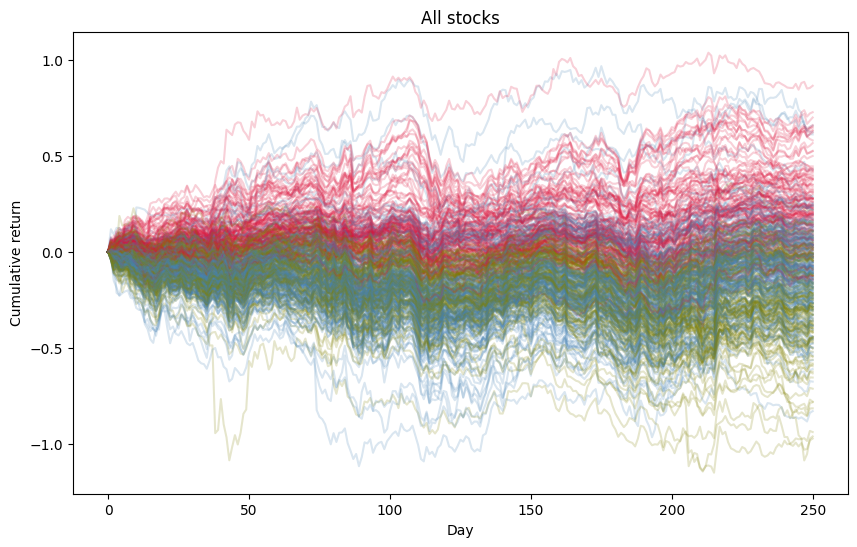

In [15]:
"""
Plot all time series
"""

fig, ax = plt.subplots(figsize=(10, 6))
colors = ["crimson", "olive", "steelblue"]
for i in tqdm(range(len(ts_return))):
    color = colors[model.labels_[i]]
    # print(ts_return.iloc[i].name, model.labels_[i])
    # print(type(ts_return.iloc[i].name))
    ax.plot(ts_return.iloc[i].ravel(), color=color, alpha=.2)
ax.set_title('All stocks')
ax.set_xlabel('Day')
ax.set_ylabel('Cumulative return')
plt.show()

In [16]:
# Make a dataframe for each cluster
cluster = []
stock_symbol = []
company_name = []
company_cap = []
for i in tqdm(range(len(ts_return))):
    cluster.append(model.labels_[i])
    stock_symbol.append(ts_return.iloc[i].name)
    company_name.append(company[ts_return.iloc[i].name])
    company_cap.append(float(market_cap_dict[ts_return.iloc[i].name] / 10**9))

# create a DataFrame
list_ts_return = list(zip(cluster, stock_symbol, company_name, company_cap))
df = pd.DataFrame(list_ts_return,
                  columns=['cluster', 'stock', 'company', 'company cap'])
df.sort_values(['cluster', 'company cap'], ascending=[True, False], inplace=True)
df = df.reset_index(drop=True)
df

100%|██████████| 473/473 [00:00<00:00, 9390.87it/s]


,cluster,stock,company,company cap
0,0,XOM,ExxonMobil,425.038479
1,0,LLY,Eli Lilly and Company,424.999027
2,0,CVX,Chevron Corporation,297.951068
3,0,MRK,Merck & Co.,277.392949
4,0,PEP,PepsiCo,256.305431
...,...,...,...,...
468,2,TPR,"Tapestry, Inc.",10.053079
469,2,PNR,Pentair,10.030609
470,2,KEY,KeyCorp,9.287172
471,2,FFIV,"F5, Inc.",9.189926


In [17]:
df.to_csv('3-cluster.csv')


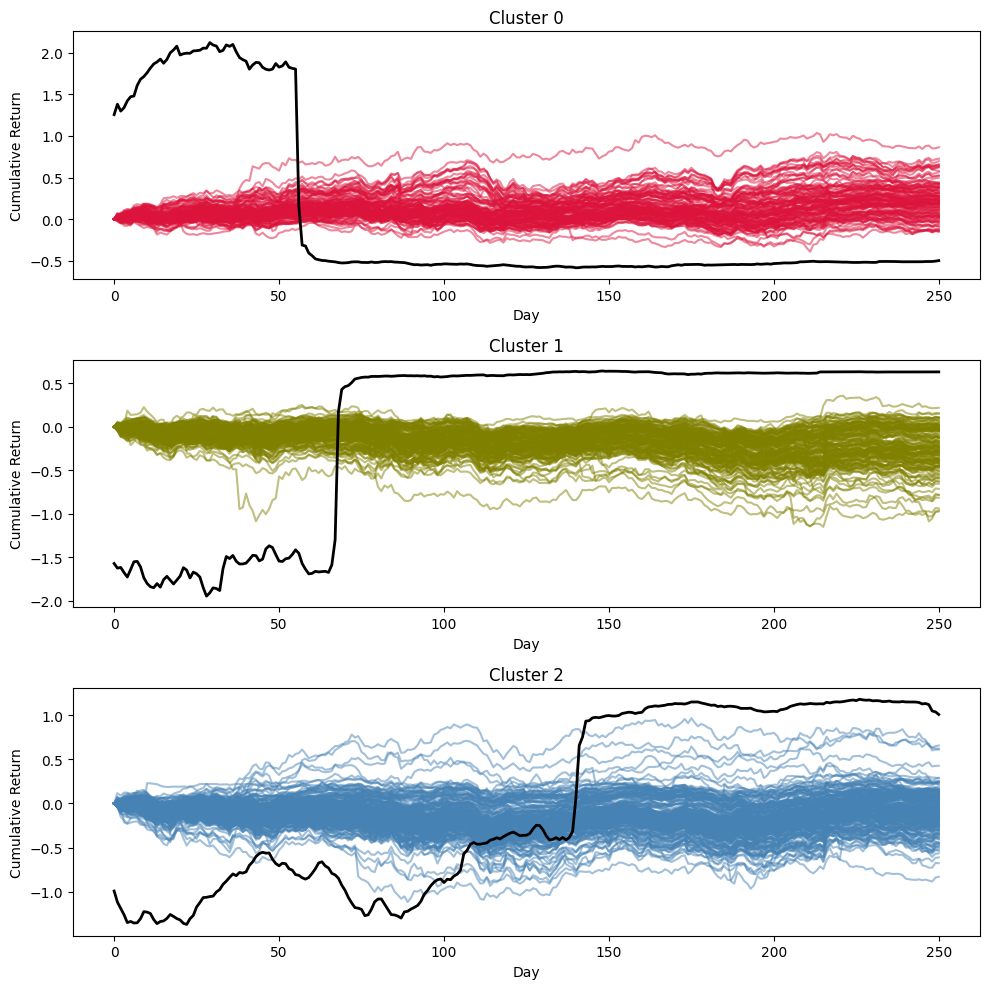

In [18]:
"""
Plot all time series in each clusters
"""

# Convert time series to 3D array
ts_return_3D = ts_return.values.reshape(ts_return.shape[0], ts_return.shape[1], 1) # reshape

# Separate time-series into clusters
cluster_0 = ts_return_3D[model.labels_ == 0]
cluster_1 = ts_return_3D[model.labels_ == 1]
cluster_2 = ts_return_3D[model.labels_ == 2]

# Plot each cluster separately
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 10))

colors = ["crimson", "olive", "steelblue"]
for i, cluster in enumerate([cluster_0, cluster_1, cluster_2]):
    ax[i].set_title(f"Cluster {i}")
    ax[i].set_xlabel("Day")
    ax[i].set_ylabel("Cumulative Return")

    for ts in cluster:
        ax[i].plot(ts, color=colors[i], alpha=0.5)
    ax[i].plot(model.cluster_centers_[i], color="black", linewidth=2)

plt.tight_layout()
plt.show()


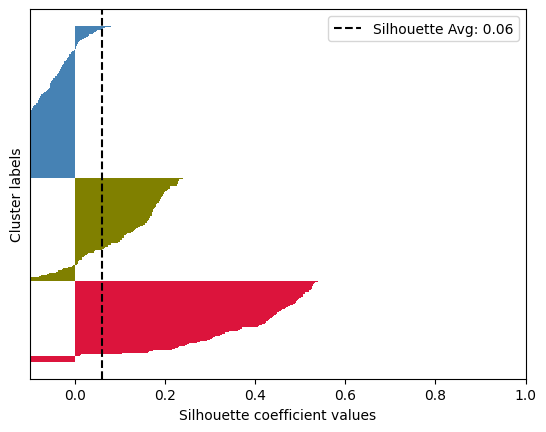

In [19]:
"""
Plot Silhouette score
"""

# Compute the silhouette scores for each sample
silhouette_vals = silhouette_samples(ts_return, model.labels_)
silhouette_avg = silhouette_score(ts_return, model.labels_)

y_lower, y_upper = 0, 0
fig, ax = plt.subplots()

colors = ["crimson", "olive", "steelblue"]
for i in range(3):
    ith_cluster_silhouette_vals = silhouette_vals[model.labels_ == i]
    ith_cluster_silhouette_vals.sort()
    size_cluster_i = ith_cluster_silhouette_vals.shape[0]
    y_upper += size_cluster_i
    color = colors[i]
    ax.barh(range(y_lower, y_upper), ith_cluster_silhouette_vals, height=1.0, color=color)
    y_lower += size_cluster_i

ax.axvline(silhouette_avg, color="black", linestyle="--")
ax.set_yticks([])
ax.set_xlim([-0.1, 1])
ax.set_xlabel("Silhouette coefficient values")
ax.set_ylabel("Cluster labels")
ax.legend(["Silhouette Avg: {:.2f}".format(silhouette_avg)])

plt.show()


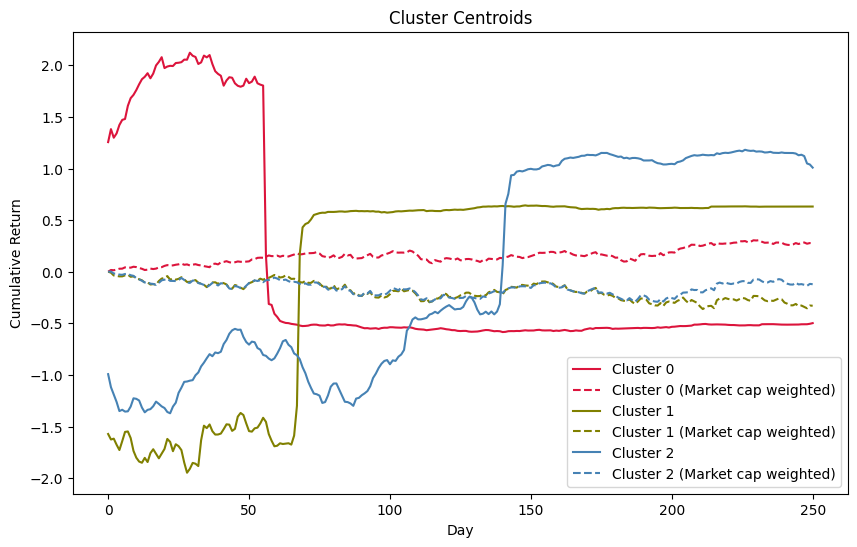

In [20]:
"""
Plot cluster centers in a single plot
"""

cluster_centers_weighted = {}
for i in range(3):
    cluster_i = ts_return[model.labels_ == i]

    # get weights
    weights = np.array([market_cap[ticker] for ticker in cluster_i.index])
    # normalize
    weights = weights / weights.sum()
    # get weighted avg
    cluster_centers_weighted[i] = np.dot(cluster_i.T, weights)


fig, ax = plt.subplots(figsize=(10, 6))
colors = ["crimson", "olive", "steelblue"]
for i in range(3):
    color = colors[i]
    ax.plot(model.cluster_centers_[i], label='Cluster {}'.format(i), color=color)
    ax.plot(cluster_centers_weighted[i], label='Cluster {} (Market cap weighted)'.format(i), color=color, linestyle='--')
ax.set_title('Cluster Centroids')
ax.legend()
ax.set_xlabel("Day")
ax.set_ylabel("Cumulative Return")
ax.set_xticks(np.arange(0, len(model.cluster_centers_[i]), 50))
plt.show()


# 2. Fama French 3 Factor

In [22]:
"""
Read daily return data
"""

df_FF3 = pd.read_csv('F-F_Research_Data_Factors_daily.CSV', index_col=0, parse_dates=True, skiprows=3).dropna(axis=0)
df_FF3 = df_FF3.loc['20220101':'20221231'] # 2022 only
df_FF3.index_name = 'Date'
df_FF3 = df_FF3/100.0 # percentage
df_FF3.head()

,Mkt-RF,SMB,HML,RF
20220103,0.0073,0.0033,0.0078,0.0
20220104,-0.0029,-0.0082,0.0362,0.0
20220105,-0.0228,-0.0146,0.0260,0.0
20220106,0.0000,0.0021,0.0175,0.0
20220107,-0.0048,-0.0132,0.0202,0.0


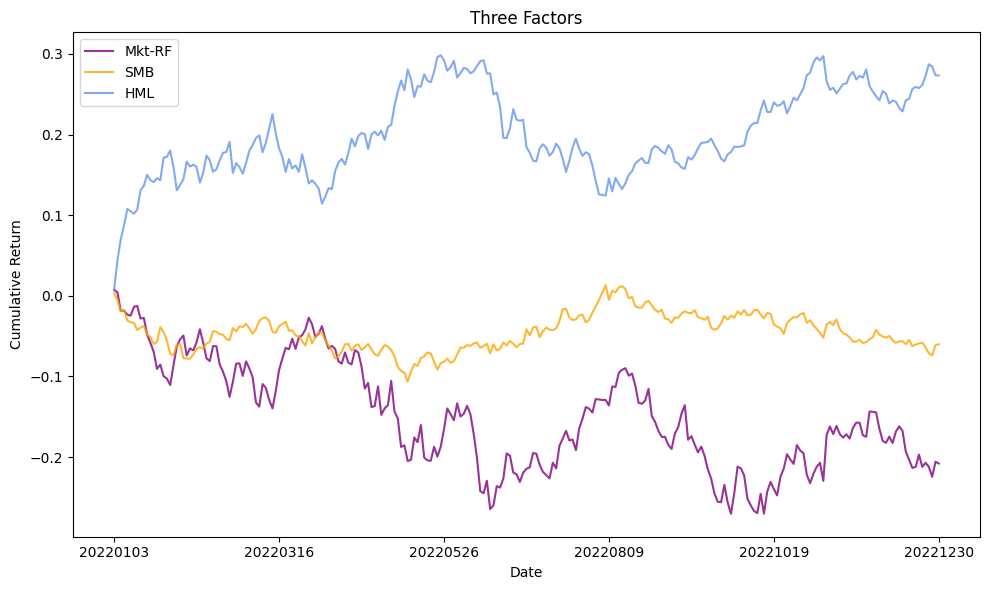

In [23]:
"""
Plot three factors in a single plt
"""

fig, ax = plt.subplots(figsize=(10, 6))
colors = ["purple", "orange", "cornflowerblue"]
for i in range(3):
    ax.plot(df_FF3.iloc[:,i].cumsum(), color=colors[i], alpha=.8, label=df_FF3.columns[i]) # cumulative return
    ax.set_title("Three Factors")
    ax.set_ylabel("Cumulative Return")
    ax.set_xlabel("Date")
    ax.set_xticks(np.arange(0, len(df_FF3), 50))
    ax.legend()

plt.tight_layout()

# 3. Regression

In [24]:
"""
Get daily price of single stock
"""

apple = yf.Ticker("AAPL")
df_AAPL = apple.history(period="1d", start="2022-01-01", end="2022-12-31")['Close']
df_AAPL.index = df_AAPL.index.date # convert index to dates, without time
df_AAPL = pd.DataFrame(df_AAPL)
df_AAPL

,Close
2022-01-03,182.009995
2022-01-04,179.699997
2022-01-05,174.919998
2022-01-06,172.000000
2022-01-07,172.169998
...,...
2022-12-23,131.860001
2022-12-27,130.029999
2022-12-28,126.040001
2022-12-29,129.610001


In [25]:
"""
Convert daily price to log return
"""

ts_return = np.log(df_AAPL/df_AAPL.shift(1))
ts_return = ts_return.replace(np.nan, 0)
ts_return

,Close
2022-01-03,0.000000
2022-01-04,-0.012773
2022-01-05,-0.026960
2022-01-06,-0.016834
2022-01-07,0.000988
...,...
2022-12-23,-0.002802
2022-12-27,-0.013976
2022-12-28,-0.031166
2022-12-29,0.027931


In [26]:
"""
Perform linear regression
"""

AAPL_regr = linear_model.LinearRegression().fit(
    X = df_FF3.iloc[:,:3].values,                               # shape (n_samples, 3)
    y = ts_return.values - df_FF3['RF'].values.reshape(-1,1)    # shape (n_samples, 1)
)

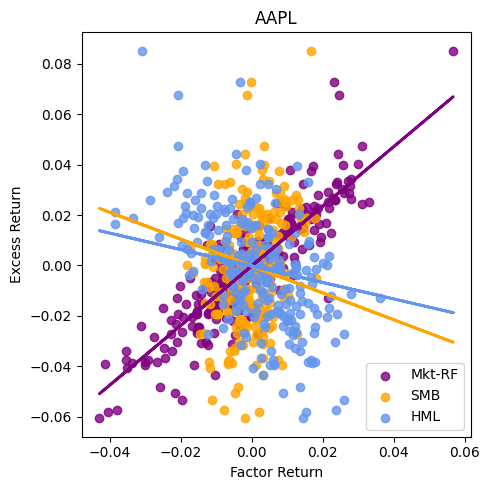

Stock: AAPL
Alpha: -0.0002
Beta for factor 1 (Mkt-RF): 1.1810
Beta for factor 2 (SMB): -0.5319
Beta for factor 3 (HML): -0.3260
R^2: 0.7974


In [27]:
"""
Plot regression fitting: 3 factors
"""

fig, ax = plt.subplots(figsize=(5, 5))
colors = ["purple", "orange", "cornflowerblue"]
for i in range(3):
      ax.scatter(df_FF3.iloc[:,i],
                  ts_return.values - df_FF3['RF'].values.reshape(-1,1),
                  color=colors[i], alpha=.8, label=df_FF3.columns[i])
      ax.plot(df_FF3,
               df_FF3 * AAPL_regr.coef_[0][i] + AAPL_regr.intercept_[0],
               color=colors[i], linewidth=2)
      ax.set_title("AAPL")
      ax.set_ylabel("Excess Return")
      ax.set_xlabel("Factor Return")
      ax.legend()

plt.tight_layout()
plt.show()

# print stock ticker
print("Stock: {}".format("AAPL"))

# print coefficients
print("Alpha: {:.4f}".format(AAPL_regr.intercept_[0]))
for i, coef in enumerate(AAPL_regr.coef_[0]):
    print("Beta for factor {} ({}): {:.4f}".format(i+1, df_FF3.columns[i], coef))

# print R^2
print("R^2: {:.4f}".format(AAPL_regr.score(df_FF3.iloc[:,:3].values, ts_return.values - df_FF3['RF'].values.reshape(-1,1))))

In [28]:
"""
Create a dataset of cluster centers
"""

cluster_0 = ts_return_.T[model.labels_ == 0]
cluster_1 = ts_return_.T[model.labels_ == 1]
cluster_2 = ts_return_.T[model.labels_ == 2]

df_cluster_means = pd.DataFrame(cluster_0.mean(), columns=['Cluster 0']).join(
                    pd.DataFrame(cluster_1.mean(), columns=['Cluster 1'])).join(
                    pd.DataFrame(cluster_2.mean(), columns=['Cluster 2']))

df_cluster_means.head()

,Cluster 0,Cluster 1,Cluster 2
Date,,,
2022-01-03,0.000000,0.000000,0.000000
2022-01-04,0.019796,0.000437,0.005680
2022-01-05,-0.005875,-0.019531,-0.019327
2022-01-06,0.009552,-0.001717,0.001154
2022-01-07,0.009268,-0.005179,-0.007266


In [29]:
"""
Perform linear regression
"""

AAPL_regr = linear_model.LinearRegression().fit(
    X = df_cluster_means.iloc[:,:3].values,                     # shape (n_samples, 3)
    y = ts_return.values - df_FF3['RF'].values.reshape(-1,1)    # shape (n_samples, 1)
)

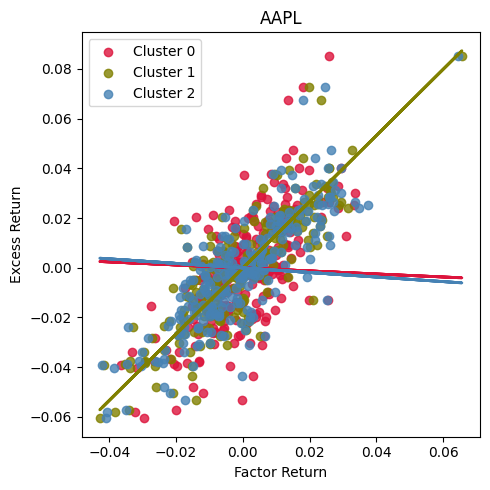

Stock: AAPL
Alpha: -0.0001
Beta for factor 1 (Cluster 0): -0.0606
Beta for factor 2 (Cluster 1): 1.3314
Beta for factor 3 (Cluster 2): -0.0915
R^2: 0.7007


In [30]:
"""
Plot regression fitting: cluster factors
"""

fig, ax = plt.subplots(figsize=(5, 5))
colors = colors = ["crimson", "olive", "steelblue"]
for i in range(3):
      ax.scatter(df_cluster_means.iloc[:,i],
                  ts_return.values - df_FF3['RF'].values.reshape(-1,1),
                  color=colors[i], alpha=.8, label=df_cluster_means.columns[i])
      ax.plot(df_cluster_means,
               df_cluster_means * AAPL_regr.coef_[0][i] + AAPL_regr.intercept_[0],
               color=colors[i], linewidth=2)
      ax.set_title("AAPL")
      ax.set_ylabel("Excess Return")
      ax.set_xlabel("Factor Return")
      ax.legend()

plt.tight_layout()
plt.show()


# print stock ticker
print("Stock: {}".format("AAPL"))

# print coefficients
print("Alpha: {:.4f}".format(AAPL_regr.intercept_[0]))
for i, coef in enumerate(AAPL_regr.coef_[0]):
    print("Beta for factor {} ({}): {:.4f}".format(i+1, df_cluster_means.columns[i], coef))

# print R^2
print("R^2: {:.4f}".format(AAPL_regr.score(df_cluster_means.iloc[:,:3].values, ts_return.values - df_FF3['RF'].values.reshape(-1,1))))